# Semantic change in LatinISE


Barbara McGillivray

This notebook contains the code for detecting semantic change in the Latin corpus LatinISe using word embeddings.

## Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [145]:
!pip install gensim==4.0

Import libraries

In [146]:
import os 
#from bs4 import BeautifulSoup
import csv
import numpy as np
import pandas as pd
#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#from nltk.corpus import stopwords
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import re
from statistics import mean
#from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

# Parameters

I set the parameters of the analysis.

In [147]:
lemmas_or_tokens = "tokens" # this can be "lemmas" or "tokens"

## Reading the files

I define the name of the folders:

In [148]:
dir_in = os.path.join("/Users", "barbaramcgillivray", "OneDrive - King's College London", "Research", "2022", "Nexus Linguarum WG4 UC4.2",  "LatinISE")
dir_in

"/Users/barbaramcgillivray/OneDrive - King's College London/Research/2022/Nexus Linguarum WG4 UC4.2/LatinISE"

I define the list of all files:

In [149]:
files = os.listdir(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens))

How many files are in the folder?


In [150]:
len(files)

1147

We only want IntraText files:

In [151]:
files = [f for f in files[:] if "IT" in f]
len(files)

553

I read the metadata file:

In [152]:
metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith("IT")]

In [153]:
metadata_df.shape

(670, 5)

In [154]:
metadata_df.columns

Index(['id', 'title', 'creator', 'date', 'type'], dtype='object')

In [155]:
metadata_df['date'].describe

<bound method NDFrame.describe of 18      382
19       -9
20      524
21     1254
22     1254
       ... 
683     116
684     116
685     116
686     116
687     533
Name: date, Length: 670, dtype: int64>

In [156]:
metadata_df.head

<bound method NDFrame.head of              id                          title  \
18   IT-LAT0001                        Vulgata   
19   IT-LAT0537                   Ars amatoria   
20   IT-LAT0011            S. Benedicti Regula   
21   IT-LAT0012   In psalmis Davidis expositio   
22   IT-LAT0014                Adoro te devote   
..          ...                            ...   
683  IT-LAT0534  De origine et situ Germanorum   
684  IT-LAT0534        De vita Iulii Agricolae   
685  IT-LAT0534         Dialogus de oratoribus   
686  IT-LAT0534                      Historiae   
687  IT-LAT0202                  Institutiones   

                                               creator  date    type  
18                                          Hieronymus   382  poetry  
19                               Ovidius Naso, Publius    -9  poetry  
20                                Benedictus Nursianus   524   prose  
21                             Thomas Aquinas: Sanctus  1254   prose  
22            

Number of works per year:

In [157]:
metadata_df0 = metadata_df.groupby(['date']).count()
metadata_df0 = metadata_df0['id']
metadata_df0

date
-450     1
-229     1
-199     3
-185     1
-149     2
        ..
 2001    4
 2002    2
 2003    1
 2004    1
 2005    1
Name: id, Length: 263, dtype: int64

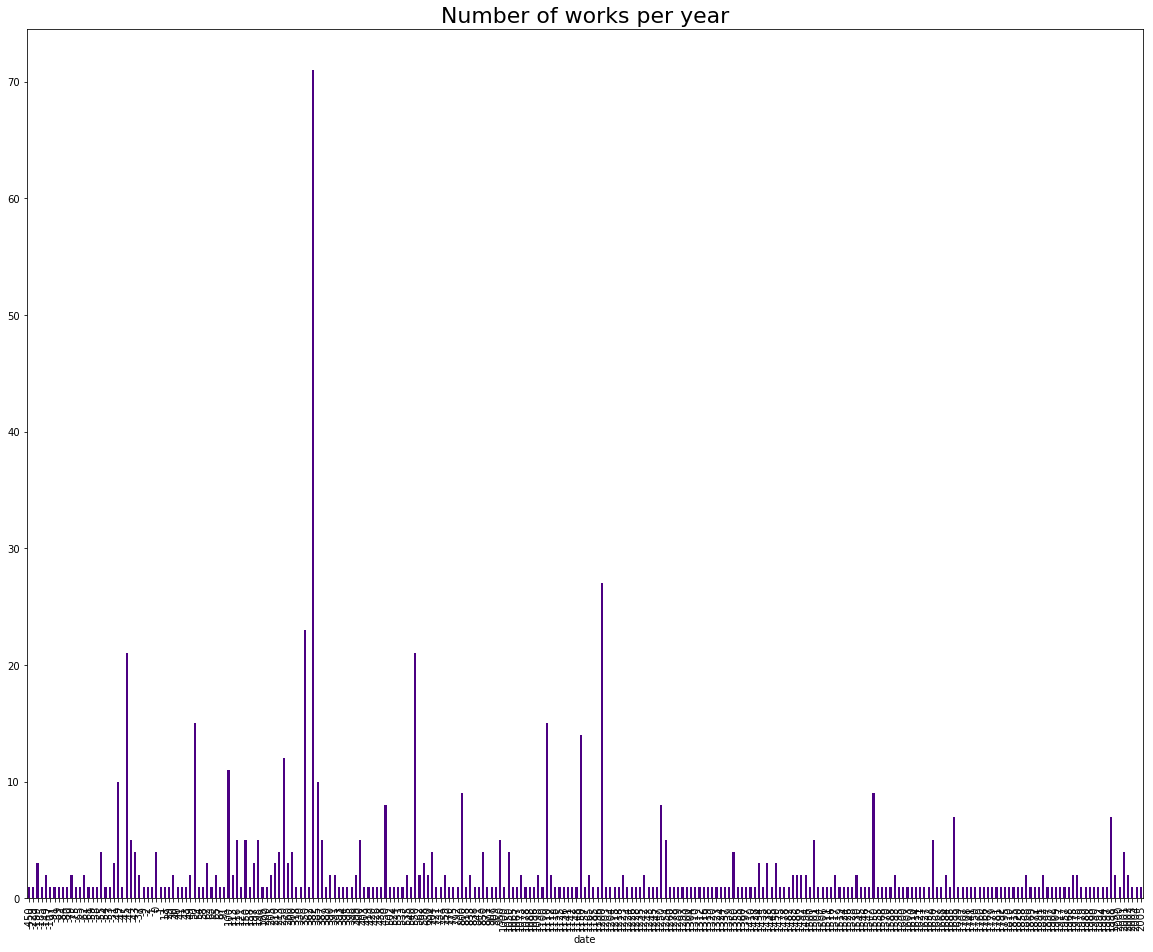

In [158]:
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per year", fontsize=22)
plt.show()

#### Stopwords exclusion and further filtering
TO BE DONE

## Train word embeddings for each time period


## Training word embeddings

Find the first and last year in the dataset:

In [159]:
first_date = min(metadata_df.date)
last_date = max(metadata_df.date)
print(first_date)
print(last_date)

-450
2005


Define size of the time intervals:

In [160]:
size_interval = 100

So there are

In [161]:
n_intervals = round((last_date-first_date)/size_interval)
n_intervals

25

time intervals.

Define the time periods and split the corpus:

In [162]:
intervals = [None]*(n_intervals+1)
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = first_date
    else:
        intervals[t] = intervals[t-1]+size_interval
    #print(intervals[t])
    
print(intervals)

[-450, -350, -250, -150, -50, 50, 150, 250, 350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250, 1350, 1450, 1550, 1650, 1750, 1850, 1950, 2050]


Add a column to the metadata_df for the time interval:

In [163]:
metadata_df['time_interval'] = ""
for t in range(len(intervals)-1):
    print(t)
    print(range(intervals[t],intervals[t+1]))
    metadata_df_t = metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1]))]
    print(metadata_df_t.date)
    metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
metadata_df

0
range(-450, -350)
169   -450
Name: date, dtype: int64
1
range(-350, -250)
Series([], Name: date, dtype: int64)
2
range(-250, -150)
137   -199
219   -199
232   -199
605   -185
649   -229
Name: date, dtype: int64
3
range(-150, -50)
57     -80
58     -79
59     -61
60     -51
79     -75
80     -65
81     -62
82     -62
84     -58
88     -55
89     -55
90     -55
91     -53
92     -54
127    -59
129    -55
130    -84
141    -89
154    -51
213    -91
215   -149
223    -79
322    -51
635   -149
638   -107
Name: date, dtype: int64
4
range(-50, 50)
19     -9
34    -49
38     49
39    -45
42    -49
48     49
50      0
54     40
61    -43
62    -43
64    -43
65      0
67    -49
70     43
73     41
76     -2
83      0
93    -45
94    -45
95    -44
97     -1
98     29
103   -43
110   -45
111   -45
112   -45
113   -45
114     0
115   -45
116   -45
119   -45
121   -45
124   -45
125   -45
126   -45
128   -45
131   -45
133   -45
135   -45
142   -49
143   -49
151   -47
152   -44
164   -49
166    13
1

,id,title,creator,date,type,time_interval
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,350
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,-50
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,450
21,IT-LAT0012,In psalmis Davidis expositio,Thomas Aquinas: Sanctus,1254,prose,1250
22,IT-LAT0014,Adoro te devote,Thomas Aquinas: Sanctus,1254,poetry,1250
...,...,...,...,...,...,...
683,IT-LAT0534,De origine et situ Germanorum,"Tacitus, Publius (Gaius) Cornelius",116,prose,50
684,IT-LAT0534,De vita Iulii Agricolae,"Tacitus, Publius (Gaius) Cornelius",116,prose,50
685,IT-LAT0534,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,50
686,IT-LAT0534,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,50


Visualise distribution of time intervals:

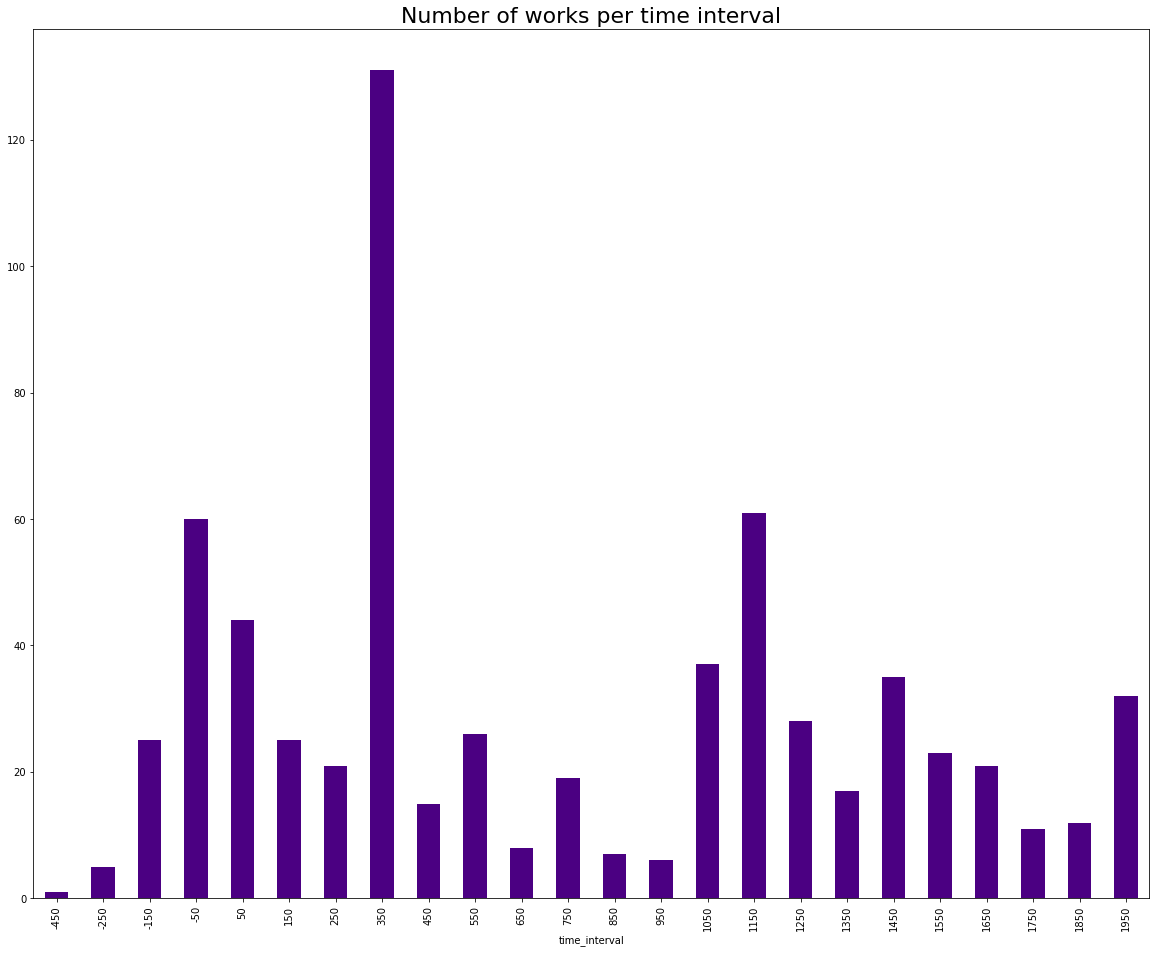

In [164]:
metadata_df0 = metadata_df.groupby(['time_interval']).count()
metadata_df0 = metadata_df0['id']
metadata_df0
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per time interval", fontsize=22)
plt.show()

WE MAY WANT TO DO SOMETHING ABOUT THIS INBALANCE

## Training word embeddings

Function for printing the vocabulary of a model

In [168]:
def print_vocab(model, top_n = None):
  count = 0
  if top_n is not None:
    for index, word in enumerate(model.wv.index_to_key):
      count+= 1
      if count < top_n:
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
  else:
    for index, word in enumerate(model.wv.index_to_key):
      print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

Function that converts dates into the standard format:

In [165]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

For each time interval, I read the texts from files and create a list of lists, i.e. a list of sentences:

In [175]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus = dict()

# I loop over all time intervals:
for t in range(n_intervals+1):
    files_corpus_t = metadata_df.loc[metadata_df['time_interval'] == intervals[t]]
    #print("1:",files_corpus_t, type(files_corpus_t))
    corpus_t = list()
    for index, df_line in files_corpus_t.iterrows():
        #print("line:",df_line['id'], df_line['time_interval'])
        sign = "+"
        #print(df_line['date'])
        if df_line['date'] < 0:
            sign = "-"
        #print("date:", convert_dates(sign, abs(df_line['date'])))
        file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
        #print("3:",file_name)
        file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
        sentences_this_file = list()
        while True:
            line = file.readline().strip()
            if line != "":
                sentences_this_file.append(line.split(" "))
            # if line is empty end of file is reached
            if not line:
                break
        file.close()
        corpus_t.append(sentences_this_file)
    #corpus_t1
    #print(len(corpus_t1[0]))
    time2corpus[t] = corpus_t


Let's inspect the corpus for the first time interval:

In [178]:
time2corpus[0][0]

[['Si', 'in', 'ius', 'vocat', ',', 'ito', '.'],
 ['ni', 'it', ',', 'antestamino', '.'],
 ['igitur', 'em', 'capito', '.'],
 ['Si',
  'calvitur',
  'pedem',
  've',
  'struit',
  ',',
  'manum',
  'endo',
  'iacito',
  '.'],
 ['si',
  'morbus',
  'aevitasve',
  'vitium',
  'escit',
  ',',
  'iumentum',
  'dato',
  '.'],
 ['si', 'nolet', ',', 'arceram', 'ne', 'sternito', '.'],
 ['assiduo', 'vindex', 'assiduus', 'esto', '.'],
 ['proletario', 'iam', 'civi', 'quis', 'volet', 'vindex', 'esto', '.'],
 ['nex',
  '...',
  'forti',
  'sanati',
  '...',
  'rem',
  'ubi',
  'pacunt',
  ',',
  'orato',
  '.'],
 ['ni',
  'pacunt',
  ',',
  'in',
  'comitio',
  'aut',
  'in',
  'foro',
  'ante',
  'meridiem',
  'caussam',
  'coiciunto',
  '.'],
 ['com', 'peroranto', 'ambo', 'praesentes', '.'],
 ['post', 'meridiem', 'praesenti', 'litem', 'addicito', '.'],
 ['si',
  'ambo',
  'praesentes',
  ',',
  'solis',
  'occasus',
  'suprema',
  'tempestas',
  'esto',
  '.'],
 [';',
  'actor',
  'dicito',
  ':',
 

And the second:

In [182]:
time2corpus[1]

[]

And the third:

In [183]:
time2corpus[2]

[[['Cogitate',
   'cum',
   'animis',
   'vetris',
   ':',
   'si',
   'quid',
   'vos',
   'per',
   'laborem',
   'recte',
   'feceritis',
   ',',
   'labor',
   'ille',
   'a',
   'vobis',
   'cito',
   'recedet',
   ',',
   'bene',
   'factum',
   'vobis',
   ',',
   'dum',
   'vivitis',
   ',',
   'non',
   'abscedet',
   ';',
   'sed',
   'si',
   'quae',
   'per',
   'voluptatem',
   'nequiter',
   'feceritis',
   ',',
   'voluptas',
   'cito',
   'abibit',
   ',',
   'nequiter',
   'factum',
   'illud',
   'apud',
   'vos',
   'smeper',
   'manebit',
   '.'],
  ['Maiores',
   'seorsum',
   'atque',
   'divorsum',
   'pretium',
   'paravere',
   'bonis',
   'atque',
   'strenuis',
   ',',
   'decurionatus',
   ',',
   'optionatus',
   ',',
   'hastas',
   'donaticas',
   ',',
   'aliosque',
   'honores',
   '.'],
  ['Asperirime', 'atque', 'arduissimo', 'aditu', '.'],
  ['Antiochus',
   'epistulis',
   'bellum',
   'gerit',
   ',',
   'calamo',
   'et',
   'atramento',
   'milita

For each time interval I train a word2vec model:

I train Word2Vec embeddings from the texts. 

`min_count`: the minimum frequency threshold allowed for a word to be included

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000.

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10.

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW.


In [180]:
start = time.time()
cbow_w5_f1_300 = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
end = time.time()
print("It has taken", round(end - start), "seconds")

It has taken 0 seconds


In [181]:
print_vocab(cbow_w5_f1_300, 10)

word #0/362 is .
word #1/362 is ,
word #2/362 is ...
word #3/362 is si
word #4/362 is ;
word #5/362 is esto
word #6/362 is in
word #7/362 is ne
word #8/362 is ni


I'VE STOPPED HERE!!!

# Semantic change with cosine similarity

I train two word2vec models, one for each dataframe corresponding to a time period. I choose the parameters that led to the best model (see script 1_Corpus_Processing script). This takes approximately 5 minutes. **You can skip this cell.**

In [ ]:
model1 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)
model2 = gensim.models.Word2Vec(df2['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)

KeyboardInterrupt: ignored

Save the models. **You can skip this cell.**

In [ ]:
models_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Models'
models = [model1, model2]
models_names = ["model1", "model2"]
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

Saving model number 1
Saving model number 2


I load the models:

In [ ]:
models_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Models'
model1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model1"))
model2 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model2"))
models = [model1, model2]
models_names = ["model1", "model2"]

What are the vocabularies of these models?

In [ ]:
print_vocab(model1, 10)

word #0/54516 is -PRON-
word #1/54516 is the
word #2/54516 is be
word #3/54516 is of
word #4/54516 is to
word #5/54516 is have
word #6/54516 is in
word #7/54516 is a
word #8/54516 is that


In [ ]:
print_vocab(model2,10)

word #0/42040 is -PRON-
word #1/42040 is the
word #2/42040 is be
word #3/42040 is of
word #4/42040 is to
word #5/42040 is in
word #6/42040 is have
word #7/42040 is a
word #8/42040 is that


In [ ]:
print(str(len(list(model1.wv.index_to_key))))
print(str(len(list(model2.wv.index_to_key))))

54516
42040


The intersection between the vocabularies of the two models:

In [ ]:
vocab1 = set(list(model1.wv.index_to_key))
vocab2 = set(list(model2.wv.index_to_key))
len(vocab1.intersection(vocab2))

23323

## Step 3. Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords <https://github.com/williamleif/histwords>.

First, I define a function to find the intersection between the vocabularies of two word2vec models:

In [ ]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

Then, I define a function for aligning two spaces with [Orthogonal Procrustes](https://simonensemble.github.io/2018-10/orthogonal-procrustes.html):

In [ ]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

Now I can apply the function to my models:

In [ ]:
smart_procrustes_align_gensim(model1, model2, words=None)

23323 23323
23323 23323


Now the two models have been aligned and have the same vocabulary:

In [ ]:
len(model1.wv.index_to_key)

23323

In [ ]:
len(model2.wv.index_to_key)

23323

In [ ]:
model1.wv.index_to_key == model2.wv.index_to_key

True

I print the vocabulary:

In [ ]:
model1.wv.index_to_key

I save the aligned models:

In [ ]:
for i in range(len(models)):
  print(models_names[i])
  models[i].save(os.path.join(models_folder, models_names[i] + "_aligned"))

model1
model2


Let's look at the similarity between two words in the two spaces:

In [ ]:
model1.wv.similarity("letter", "note")

0.7763005

In [ ]:
model2.wv.similarity("letter", "note")

0.8022866

## Step 4: Measure change

Now I can measure the cosine similarity between the embedding of a word in the first time period and the embedding of the same word in the second time period. 

Let's define a function that calculates the cosine similarity between the embedding of a word in t1 and the embedding of the same word in t2:

In [ ]:
def cosine_similarity(word):
  sc = 1-spatial.distance.cosine(model1.wv[word], model2.wv[word])
  return sc

Now I calculate the semantic similarity for all words in the vocabulary, and store this in the dataframe cosine_similarity; I also add a column for the frequency of the word in the first space and another one for its frequency in the second space:

In [ ]:
cosine_similarity_df = pd.DataFrame(([w, cosine_similarity(w), model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in model1.wv.index_to_key), columns = ('Word', 'Cosine_similarity', "Frequency_t1", "Frequency_t2"))
cosine_similarity_df

,Word,Cosine_similarity,Frequency_t1,Frequency_t2
0,-PRON-,0.948136,284506,174605
1,the,0.921887,129459,90613
2,be,0.936264,102383,62432
3,of,0.909740,87876,59302
4,to,0.920282,78925,52600
...,...,...,...,...
23318,soreness,0.942521,2,1
23319,263,0.919004,2,1
23320,wetness,0.939036,2,1
23321,xxviii,0.968271,2,1


Visualise the distribution of the semantic similarity scores with a histogram:

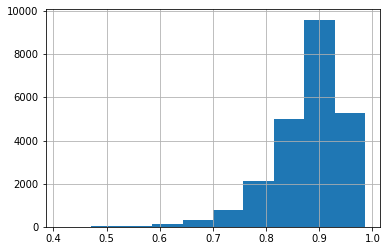

In [ ]:
hist = cosine_similarity_df['Cosine_similarity'].hist()

Now I sort by decreasing semantic change score:

In [ ]:
cosine_similarity_df_sorted = cosine_similarity_df.sort_values(by='Cosine_similarity', ascending=True)
cosine_similarity_df_sorted.head()

,Word,Cosine_similarity,Frequency_t1,Frequency_t2
5352,stud,0.413877,23,14
4021,1879,0.467864,36,23
2635,Utricularia,0.468761,68,43
5501,Caspary,0.471753,22,14
3717,Sara,0.474424,41,26


I add the total frequency:

In [ ]:
cosine_similarity_df_sorted["Total_Frequency"] = cosine_similarity_df_sorted["Frequency_t1"]+cosine_similarity_df_sorted["Frequency_t2"]
cosine_similarity_df_sorted

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency
5352,stud,0.413877,23,14,37
4021,1879,0.467864,36,23,59
2635,Utricularia,0.468761,68,43,111
5501,Caspary,0.471753,22,14,36
3717,Sara,0.474424,41,26,67
...,...,...,...,...,...
21188,Familie,0.982051,2,2,4
11439,mit,0.982179,7,4,11
16029,vom,0.983580,4,2,6
17034,avec,0.985625,3,2,5


I add a column with the category (function word, foreign word, numeral, and proper noun).

List of function words (from https://www.eltconcourse.com/training/initial/lexis/function_words.html)

In [ ]:
function_words = ['after', 'although', 'and', 'as', 'because', 'before', 'both', 'but', 'either', 'for', 'however', 'if','neither','nor','once','or','since','so','than','that','therefore','though','thus','till','unless','until','when','whenever','where','wherever','whether','while','yet	a','all','another','any','both','each','either','every','her','his','its','my','neither','no','other','our','per','some','that','the','their','these','this','those','whatever','whichever','your	about','above','across','after','against','ahead','along','among','amongst','around','as','at','bar','before','behind','below','beneath','beside','besides','between','beyond','but','by','down','during','except','for','from','in','inside','into','less','like	near','of','off','on','onto','opposite','outside','over','past','per','round','save','since','through','till','to','toward','under','underneath','until','up','upon','with','within','without	all','another','any','anybody','anyone','anything','both','each','either','everybody','everyone','everything','few','he','I','it','many','mine','neither','nobody','none','nothing','one','other','several','she','some','somebody','someone','something','that','these','they	this','those','we','what','whatever','which','whichever','who','whoever','whom','whose','you']

Applying the detect package doesn't work on individual words so I use the NLTK's English dictionary instead:

In [ ]:
#semantic_change.df.sorted['Language'] = semantic_change.df.sorted['Word'].apply(detect) 
import nltk
nltk.download('words')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())
len(english_vocab)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


234377

In [ ]:
# create a list of our conditions
conditions = [
    (cosine_similarity_df_sorted['Word'].isin(function_words)), # function words
    ((cosine_similarity_df_sorted.Word.str.isdigit()) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?1st$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?2nd$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?3rd$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (cosine_similarity_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(cosine_similarity_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
cosine_similarity_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
cosine_similarity_df_sorted

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
5352,stud,0.413877,23,14,37,
4021,1879,0.467864,36,23,59,Numeral
2635,Utricularia,0.468761,68,43,111,Proper noun
5501,Caspary,0.471753,22,14,36,Proper noun
3717,Sara,0.474424,41,26,67,Proper noun
...,...,...,...,...,...,...
21188,Familie,0.982051,2,2,4,Proper noun
11439,mit,0.982179,7,4,11,Foreign word
16029,vom,0.983580,4,2,6,Foreign word
17034,avec,0.985625,3,2,5,Foreign word


I save this to a file:

In [ ]:
output_folder = '/content/drive/MyDrive/2021/Darwin paper/Files/Semantic_change_output/'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
cosine_similarity_df_sorted.to_csv(os.path.join(output_folder, 'Cosine_similarity_all_words.csv'), encoding='utf-8')

The top most changed words:

In [ ]:
cosine_similarity_df_sorted.head(100)

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
5352,stud,0.413877,23,14,37,
4021,1879,0.467864,36,23,59,Numeral
2635,Utricularia,0.468761,68,43,111,Proper noun
5501,Caspary,0.471753,22,14,36,Proper noun
3717,Sara,0.474424,41,26,67,Proper noun
...,...,...,...,...,...,...
2366,Upper,0.589116,78,50,128,Proper noun
6237,Buckley,0.589188,18,11,29,Proper noun
5749,Mormodes,0.590913,20,13,33,Proper noun
2857,Bird,0.591440,60,38,98,Proper noun


In [ ]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] =="scientist"]

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
6456,scientist,0.884423,17,11,28,


I plot the terms by their total frequency and semantic change score:

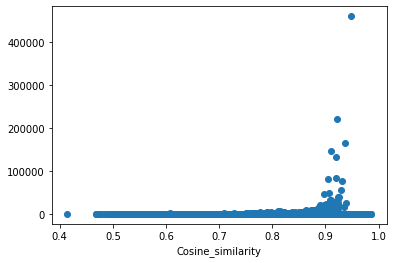

In [ ]:
ax = cosine_similarity_df_sorted.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

Which words are the outliers? Function words and *Darwin*:

In [ ]:
cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] > 10000].Word.tolist()

['would',
 'Darwin',
 'by',
 'or',
 'and',
 'from',
 'more',
 'at',
 'an',
 'may',
 'one',
 'see',
 'in',
 'think',
 '  ',
 'about',
 'on',
 'with',
 'of',
 'do',
 'any',
 'some',
 'send',
 'much',
 'if',
 'can',
 'this',
 'to',
 'but',
 'have',
 'will',
 'the',
 'for',
 'as',
 'which',
 'so',
 'not',
 'that',
 'a',
 'all',
 'be',
 'very',
 '-PRON-']

I exclude the outliers:

In [ ]:
cosine_similarity_df_sorted_nooutliers = cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] < 10000]
cosine_similarity_df_sorted_nooutliers.shape

(23280, 6)

Plot:

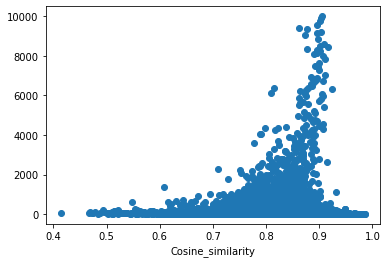

In [ ]:
ax = cosine_similarity_df_sorted_nooutliers.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

What is the semantic change of the words we have chosen?

In [ ]:
words_chosen = ['protoplasm', 'curious', 'fertilisation', 'fertilise', 'analogy', 'analogous', 'homology', 'homologous', 'cleistogamic', 'physiology', 'physiological', 'ferment', 'science', 'scientist', 'scientific', 'evolution', 'evolutionary', 'evolve']

In [ ]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] == "scientist"]


,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
6456,scientist,0.884423,17,11,28,


In [ ]:
cosine_similarity_chosen = cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'].isin(words_chosen)]
cosine_similarity_chosen.to_csv(os.path.join(output_folder, 'cosine_similarity_chosen_words.csv'), encoding='utf-8')
cosine_similarity_chosen

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
2636,protoplasm,0.638491,68,43,111,
5403,ferment,0.801100,22,14,36,
943,fertilisation,0.808386,275,170,445,Foreign word
941,fertilise,0.818965,277,170,447,Foreign word
2325,physiology,0.831795,81,52,133,
1984,physiological,0.837908,101,65,166,
421,scientific,0.839232,656,430,1086,
4118,homology,0.842890,35,22,57,
1179,analogous,0.853460,211,133,344,
226,curious,0.864781,1283,840,2123,


In [ ]:
min(cosine_similarity_chosen.Cosine_similarity)

0.6384905576705933

In [ ]:
min(cosine_similarity_chosen.Total_Frequency)

28

In [ ]:
min(cosine_similarity_df_sorted.Cosine_similarity)

0.4138766825199127

Now I focus on those words that have a frequency higher than min(semantic_change_chosen.Total_Frequency). How many are there?

In [ ]:
cosine_similarity_df_sorted_filtered = cosine_similarity_df_sorted_nooutliers.loc[(cosine_similarity_df_sorted_nooutliers['Total_Frequency'] >= min(cosine_similarity_chosen.Total_Frequency))]
cosine_similarity_df_sorted_filtered.shape

(6480, 6)

Which words are these words?

In [ ]:
cosine_similarity_df_sorted_filtered

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
5352,stud,0.413877,23,14,37,
4021,1879,0.467864,36,23,59,Numeral
2635,Utricularia,0.468761,68,43,111,Proper noun
5501,Caspary,0.471753,22,14,36,Proper noun
3717,Sara,0.474424,41,26,67,Proper noun
...,...,...,...,...,...,...
4779,My,0.956321,28,17,45,Proper noun
5564,F.L.S.,0.956396,21,14,35,Foreign word
5011,servt,0.956619,26,16,42,Foreign word
5454,Truly,0.965719,22,14,36,Proper noun


Neighbours of *fertilisation* in the two time periods:

In [ ]:
print(model1.wv.similar_by_word("fertilisation", 10))
print(model2.wv.similar_by_word("fertilisation", 10))
cosine_similarity_df_sorted_filtered[cosine_similarity_df_sorted_filtered['Word'] == "fertilisation"]

[('fertilization', 0.8758518695831299), ('contrivance', 0.8129968643188477), ('impregnation', 0.8084515333175659), ('Passiflora', 0.8014850616455078), ('agency', 0.7770189046859741), ('orchid', 0.7742666602134705), ('impotence', 0.7644632458686829), ('self', 0.7620887756347656), ('orchis', 0.7603682279586792), ('Catasetum', 0.7582208514213562)]
[('fertilization', 0.9029185175895691), ('carnivorous', 0.7927517294883728), ('Alpine', 0.7897111177444458), ('Self', 0.7889798879623413), ('fertilize', 0.7871734499931335), ('alpine', 0.786170482635498), ('cross-', 0.7830774188041687), ('fertilise', 0.7808493971824646), ('contrivance', 0.7806875109672546), ('Lepidoptera', 0.7777403593063354)]


,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
943,fertilisation,0.808386,275,170,445,Foreign word


I create a list for these words:

In [ ]:
highfreq_words = cosine_similarity_df_sorted_filtered.Word.tolist()
highfreq_words[:10]

['stud',
 '1879',
 'Utricularia',
 'Caspary',
 'Sara',
 'Tropics',
 'Pheasant',
 'Mivart',
 'cleavage',
 'Self']

Now I annotate the plot with these:

In [ ]:
cosine_similarity_df_sorted_filtered_p = cosine_similarity_df_sorted_filtered[['Word','Cosine_similarity', 'Total_Frequency']]
fig, ax = plt.subplots()
cosine_similarity_df_sorted_filtered_p.plot('Cosine_similarity', 'Total_Frequency', kind='scatter', ax=ax)
for k, v in cosine_similarity_df_sorted_filtered_p.iterrows():
  word = v['Word']
  sc = v['Cosine_similarity']
  f = v['Total_Frequency']
  #print("w", v['Word'])
  #print("sc:", str(sc))
  #print("f:", str(f))
  ax.annotate(word, xy=(sc,f))

What are the neighbours of these words in the two spaces?

In [ ]:
count = 0
for word in highfreq_words:
  count += 1
  if count < 10:
    print(word)
    print("Neighbours in first space:")
    print(model1.wv.similar_by_word(word, 10))
    print("Neighbours in second space:")
    print(model2.wv.similar_by_word(word, 10))

I print this to an output file:

In [ ]:
outfile = open(os.path.join(output_folder, 'Neighbours_freq_words.csv'), 'w+')

# Write header row:
outfile.write("Word, followed by  neighbours in first space and neighbours in second space\n") 
for word in highfreq_words:
  #print(word)
  #print("Neighbours in first space:")
  #print(model1.wv.similar_by_word(word, 10))
  #print("Neighbours in second space:")
  #print(model2.wv.similar_by_word(word, 10))
  for (w,c) in model1.wv.similar_by_word(word, 10):
    outfile.write(word+"\t" + w+"\t"+str(c))
  outfile.write("\n")
  for (w,c) in model2.wv.similar_by_word(word, 10):
    outfile.write(word+"\t"+w+"\t"+str(c))
  outfile.write("\n")
  
outfile.close()

## Semantic change detection using neighbours

We're going to implement the method proposed by Gonen, H., Jawahar, G., Seddah, D., & Goldberg, Y. (2020). Simple, Interpretable and Stable Method for Detecting Words with Usage Change across Corpora. In Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics (pp. 538–555). https://doi.org/10.18653/v1/2020.acl-main.51 

Print the histogram of the frequency of the words in the corpus:

                Freq
count  73233.000000 
mean   59.930646    
std    2254.361411  
min    1.000000     
25%    1.000000     
50%    2.000000     
75%    5.000000     
max    459111.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc8a42b390>]],
      dtype=object)

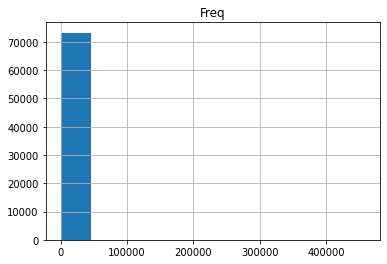

In [ ]:
model = sg_w5_f1
vocab = model.wv.index_to_key
frequencies = list()
for w in vocab:
  frequencies.append(model.wv.get_vecattr(w, "count"))
print(pd.DataFrame({'Word':vocab,'Freq':frequencies}).describe())
pd.DataFrame({'Word':vocab,'Freq':frequencies}).hist()

I exclude all words with frequency lower than min_freq and higher than max_freq:

In [ ]:
def filter_words(model, min_freq, max_freq):
  vocab = model.wv.index_to_key
  vocab_filtered = []
  for w in vocab:
    if model.wv.get_vecattr(w, "count") <max_freq and model.wv.get_vecattr(w, "count")>min_freq:
      vocab_filtered.append(w)
  return vocab_filtered

vocab1_filtered = filter_words(model1,2,50000)
vocab2_filtered = filter_words(model2,2,50000)
vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))

How many words?

In [ ]:
print(str(len(vocab_filtered)))

15877


Distribution of filtered word frequencies:

               Freq
count  22531.000000
mean   141.854689  
std    1438.893306 
min    4.000000    
25%    6.000000    
50%    11.000000   
75%    34.000000   
max    83971.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc77944b90>]],
      dtype=object)

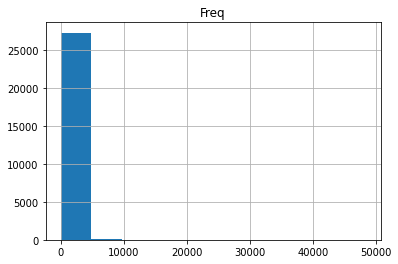

In [ ]:
word2freq = pd.DataFrame({'Word':vocab,'Freq':frequencies})
print(word2freq[(word2freq.Freq<100000) & (word2freq.Freq>3)].describe())
word2freq[(word2freq.Freq<50000) & (word2freq.Freq>2)].hist()

I extract the top_n neighbours and save them in a dictionary mapping a word to the list of its 100 neighbours:

In [ ]:
def extract_neighbours(w2vmodel, vocab_list, top_n):
  count = 0
  word2neighbours = dict()
  for w in vocab_list:
    count += 1
    #if (count % 100) == 0:
    #  print(str(count), "out of", str(len(vocab_list)), w)
    neighbours = w2vmodel.wv.similar_by_word(w, top_n)
    #print(str(neighbours))
    neighbour_list = list()
    for n in neighbours:
      neighbour_list.append(n[0])
    word2neighbours[w] = neighbour_list
  return word2neighbours

I apply this to model1 and model2 for filtered words:

In [ ]:
#word2neighbours1 = extract_neighbours(model1, model1.wv.index_to_key)
word2neighbours1 = extract_neighbours(model1, vocab1_filtered, 100)
#word2neighbours2 = extract_neighbours(model2, model2.wv.index_to_key)
word2neighbours2 = extract_neighbours(model2, vocab2_filtered, 100)

100 out of 20607 ever
200 out of 20607 several
300 out of 20607 nearly
400 out of 20607 genera
500 out of 20607 stand
600 out of 20607 towards
700 out of 20607 easily
800 out of 20607 heart
900 out of 20607 material
1000 out of 20607 daresay
1100 out of 20607 unfortunately
1200 out of 20607 Edit
1300 out of 20607 sleep
1400 out of 20607 specific
1500 out of 20607 plenty
1600 out of 20607 acquaintance
1700 out of 20607 wear
1800 out of 20607 freely
1900 out of 20607 blind
2000 out of 20607 strata
2100 out of 20607 subscription
2200 out of 20607 excessively
2300 out of 20607 eight
2400 out of 20607 majority
2500 out of 20607 Anne
2600 out of 20607 Sciences
2700 out of 20607 establishment
2800 out of 20607 transfer
2900 out of 20607 proposition
3000 out of 20607 thread
3100 out of 20607 breast
3200 out of 20607 impregnate
3300 out of 20607 peach
3400 out of 20607 estate
3500 out of 20607 omission
3600 out of 20607 eyelid
3700 out of 20607 gum
3800 out of 20607 encouragement
3900 out of 20

For every word in the intersection between the two vocabularies, compare its neighbours in t1 and its neighbours in t2; the semantic change score is the number of shared neighbours between the two divided by 100.
NB This is different from the formula in Gonen et al. (2020), who take the negative of the overlap.

In [ ]:
#vocab_12 = list(set(model1.wv.index_to_key) & set(model2.wv.index_to_key))
w2sc = dict()
for w in vocab_filtered:
  sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
  w2sc[w] = sc

I have saved these scores in the w2sc dictionary. Now I sort it by decreasing score to see which words changed the most:

In [ ]:
w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
w2sc_sorted[:10]

[('2ndly', 0.0),
 ('Ohio', 0.0),
 ('dissolution', 0.0),
 ('tailless', 0.0),
 ('debateable', 0.0),
 ('FD', 0.0),
 ('opake', 0.0),
 ('Hampstead', 0.0),
 ('prohibit', 0.0),
 ('Saporta', 0.0)]

What are the most changed words?

In [ ]:
top_changed = [i[0] for i in w2sc_sorted][:20]
top_changed

['2ndly',
 'Ohio',
 'dissolution',
 'tailless',
 'debateable',
 'FD',
 'opake',
 'Hampstead',
 'prohibit',
 'Saporta',
 'Afghanistan',
 'Chloride',
 'breaking',
 'grower',
 'Camels',
 'aqueous',
 'painting',
 'Desterro',
 'Divinity',
 'Monotremata']

What are their neighbours?

In [ ]:
for w in top_changed:
  print(w)
  print(str(word2neighbours1[w]))
  print(str(word2neighbours2[w]))

2ndly
['rigorously', 'compensation', 'Jollofs', 'showing', 'fecundity', 'intercross', 'disproportion', 'armature', 'mating', 'crucial', 'nutation', 'mammæ', 'albinism', 'criterion', 'initially', 'obliteration', 'caprice', 'elongation', 'interbreeding', 'silently', 'degeneration', 'axillary', 'offspre', 'centripetal', 'naturalisation', 'intermarry', 'susceptible', 'comprehensible', 'circumnutation', 'supposed', 'intensify', 'enlargement', 'inferiority', 'paralell', 'tenacity', 'abnormality', 'grouping', 'inappreciable', 'acorn', 'lepidoptera', 'acting', 'producer', 'proportionate', 'marrow', 'compactness', 'sufficiency', 'severest', 'fatten', 'basic', 'locomotive', 'substitution', 'heterogeneous', 'ramification', 'Hermaphrodites', 'extinguish', 'scottish', 'correlated', 'coloring', 'spatial', 'interstice', 'assumed', 'grasshopper', 'supersede', 'geometrical', 'adaptive', 'concealment', 'economic', 'smallness', 'counteract', 'magnitude', 'practicable', 'hooked', 'defensive', 'generalize'

In [ ]:
neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_filtered), columns = ('Word', 'Neighbour_score', "Frequency_t1", "Frequency_t2"))
neighbours_df.describe()

,Neighbour_score,Frequency_t1,Frequency_t2
count,15877.000000,15877.000000,15877.000000
mean,0.064380,119.614789,75.244505
std,0.089923,959.505965,620.545063
min,0.000000,4.000000,3.000000
25%,0.010000,6.000000,4.000000
50%,0.020000,12.000000,8.000000
75%,0.090000,37.000000,23.000000
max,0.670000,49107.000000,31456.000000


Visualise the distribution of the semantic change scores with a histogram:

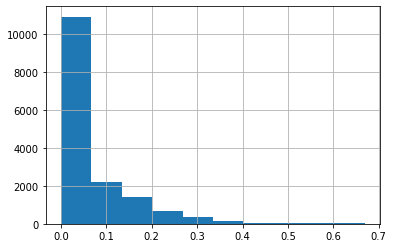

In [ ]:
hist = neighbours_df['Neighbour_score'].hist()

Now I sort by increasing neighbour score:

In [ ]:
neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
neighbours_df_sorted.head(50)

,Word,Neighbour_score,Frequency_t1,Frequency_t2
12096,quoad,0.0,6,4
7091,leak,0.0,5,3
10971,Langer,0.0,4,3
7098,collaborator,0.0,8,5
7099,groom,0.0,7,5
10966,surprized,0.0,5,3
4422,Provence,0.0,7,5
4421,1803,0.0,4,3
7102,Sequoia,0.0,5,3
10958,carve,0.0,5,3


I add the total frequency:

In [ ]:
neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"]+neighbours_df_sorted["Frequency_t2"]
neighbours_df_sorted

,Word,Neighbour_score,Frequency_t1,Frequency_t2,Total_Frequency
12096,quoad,0.00,6,4,10
7091,leak,0.00,5,3,8
10971,Langer,0.00,4,3,7
7098,collaborator,0.00,8,5,13
7099,groom,0.00,7,5,12
...,...,...,...,...,...
7720,5,0.63,786,492,1278
8669,December,0.63,137,86,223
12051,April,0.64,214,136,350
549,June,0.65,243,153,396


I add a column with the category (function word, foreign word, numeral, and proper noun).

In [ ]:
# create a list of our conditions
conditions = [
    (neighbours_df_sorted['Word'].isin(function_words)), # function words
    ((neighbours_df_sorted.Word.str.isdigit()) | (neighbours_df_sorted['Word'].str.match('^\d*?1st$')) | (neighbours_df_sorted['Word'].str.match('^\d*?2nd$')) | (neighbours_df_sorted['Word'].str.match('^\d*?3rd$')) | (neighbours_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(neighbours_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
neighbours_df_sorted

,Word,Neighbour_score,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
12096,quoad,0.00,6,4,10,Foreign word
7091,leak,0.00,5,3,8,
10971,Langer,0.00,4,3,7,Proper noun
7098,collaborator,0.00,8,5,13,
7099,groom,0.00,7,5,12,
...,...,...,...,...,...,...
7720,5,0.63,786,492,1278,Numeral
8669,December,0.63,137,86,223,Proper noun
12051,April,0.64,214,136,350,Proper noun
549,June,0.65,243,153,396,Proper noun


I save this to a file:

In [ ]:
output_folder = '/content/drive/MyDrive/2021/Darwin paper/Files/Semantic_change_output/'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
neighbours_df_sorted.to_csv(os.path.join(output_folder, 'all_words_neighbourscore.csv'), encoding='utf-8')

## Comparison of the two methods for semantic change detection

In [ ]:
neighbours_df_sorted.sort_values(by='Word', ascending=True)

,Word,Neighbour_score,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
3520,,0.18,839,519,1358,Foreign word
7518,,0.41,28553,20542,49095,Foreign word
15365,,0.04,13,8,21,Foreign word
15392,,0.00,9,6,15,Foreign word
11324,,0.00,7,4,11,Foreign word
...,...,...,...,...,...,...
3626,☞,0.00,4,3,7,Foreign word
5262,♀,0.05,284,173,457,Foreign word
15467,♂,0.08,232,146,378,Foreign word
11229,〈,0.00,22,14,36,Foreign word


In [ ]:
cosine_similarity_df_sorted.sort_values(by='Word', ascending=True)

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
337,,0.608472,839,519,1358,Foreign word
9,,0.907147,28553,20542,49095,Foreign word
7694,,0.816608,13,8,21,Foreign word
9397,,0.743481,9,6,15,Foreign word
11189,,0.752918,7,4,11,Foreign word
...,...,...,...,...,...,...
17650,☿,0.930398,3,2,5,Foreign word
923,♀,0.657241,284,173,457,Foreign word
1085,♂,0.699295,232,146,378,Foreign word
5513,〈,0.627050,22,14,36,Foreign word


In [ ]:
semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'inner')
semantic_change_2methods

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
0,stud,0.413877,23,14,37,,0.00
1,1879,0.467864,36,23,59,Numeral,0.00
2,Utricularia,0.468761,68,43,111,Proper noun,0.00
3,Caspary,0.471753,22,14,36,Proper noun,0.00
4,Sara,0.474424,41,26,67,Proper noun,0.00
...,...,...,...,...,...,...,...
15872,516,0.981149,5,3,8,Numeral,0.09
15873,dawkin,0.981757,9,6,15,,0.24
15874,nach,0.981983,8,5,13,,0.37
15875,mit,0.982179,7,4,11,Foreign word,0.34


I integrate the neighbour score in the file:

In [ ]:
semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'outer')
semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'all_words_2scores.csv'), encoding='utf-8')
semantic_change_2methods_all

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
0,stud,0.413877,23,14,37,,0.00
1,1879,0.467864,36,23,59,Numeral,0.00
2,Utricularia,0.468761,68,43,111,Proper noun,0.00
3,Caspary,0.471753,22,14,36,Proper noun,0.00
4,Sara,0.474424,41,26,67,Proper noun,0.00
...,...,...,...,...,...,...,...
23318,Familie,0.982051,2,2,4,Proper noun,NaN
23319,mit,0.982179,7,4,11,Foreign word,0.34
23320,vom,0.983580,4,2,6,Foreign word,NaN
23321,avec,0.985625,3,2,5,Foreign word,NaN


In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'] =="scientist"]

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
10055,scientist,0.884423,17,11,28,,0.07


I plot the terms by two semantic change scores:

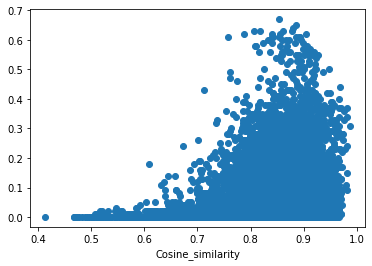

In [ ]:
ax = semantic_change_2methods.set_index('Cosine_similarity')['Neighbour_score'].plot(style='o')

In [ ]:
semantic_change_2methods_all.corr(method="spearman")

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
Cosine_similarity,1.000000,-0.642626,-0.639241,-0.642509,0.086991
Frequency_t1,-0.642626,1.000000,0.988534,0.999005,0.669929
Frequency_t2,-0.639241,0.988534,1.000000,0.993780,0.669938
Total_Frequency,-0.642509,0.999005,0.993780,1.000000,0.669454
Neighbour_score,0.086991,0.669929,0.669938,0.669454,1.000000


There seems to be a positive correlation: the higher the cosine similarity the higher the neighbour similarity.



In [ ]:
semantic_change_2methods_all.describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,23323.000000,23323.000000,23323.000000,23323.000000,15877.000000
mean,0.878470,113.853664,71.983321,185.836985,0.064380
std,0.066656,2445.143893,1548.956199,3992.675708,0.089923
min,0.413877,2.000000,1.000000,3.000000,0.000000
25%,0.847949,3.000000,2.000000,5.000000,0.010000
50%,0.894638,7.000000,4.000000,11.000000,0.020000
75%,0.926540,20.000000,13.000000,33.000000,0.090000
max,0.986384,284506.000000,174605.000000,459111.000000,0.670000


Scores for chosen words:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.841837,249.937500,160.750000,410.687500,0.156250
std,0.063446,344.647157,225.478602,570.107793,0.110144
min,0.638491,17.000000,11.000000,28.000000,0.010000
25%,0.828587,33.000000,20.750000,53.750000,0.065000
50%,0.848175,102.500000,65.500000,168.000000,0.145000
75%,0.877057,275.500000,170.000000,445.500000,0.220000
max,0.920679,1283.000000,840.000000,2123.000000,0.370000


Scores for not chosen words:

In [ ]:
semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,23307.000000,23307.000000,23307.000000,23307.000000,15861.000000
mean,0.878495,113.760244,71.922384,185.682628,0.064287
std,0.066652,2445.964839,1549.475495,3994.015460,0.089858
min,0.413877,2.000000,1.000000,3.000000,0.000000
25%,0.847980,3.000000,2.000000,5.000000,0.010000
50%,0.894681,7.000000,4.000000,11.000000,0.020000
75%,0.926564,20.000000,13.000000,33.000000,0.090000
max,0.986384,284506.000000,174605.000000,459111.000000,0.670000


Compare the two means:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]]

0.8418374210596085

I define a list of words that I expect did not change:

In [ ]:
not_changed = ['the', 'it', 'for', 'a', 'at', 'in', 'be', 'of', 'on', 'over', 'under']

Then I look at their scores:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)]

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
3219,under,0.810521,1602,1013,2615,Function word,0.10
7586,over,0.864803,2174,1361,3535,Function word,0.16
12799,at,0.901483,14449,8417,22866,Function word,0.07
13366,in,0.904911,49107,31456,80563,Function word,0.04
14199,on,0.909373,19810,12670,32480,Function word,0.16
14254,of,0.909740,87876,59302,147178,Function word,NaN
16570,the,0.921887,129459,90613,220072,Function word,NaN
16746,for,0.922878,23843,15529,39372,Function word,0.12
18361,a,0.930757,46715,29808,76523,,0.06
19488,be,0.936264,102383,62432,164815,,NaN


In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,10.000000,10.000000,10.000000,10.000000,7.000000
mean,0.901262,47741.800000,31260.100000,79001.900000,0.101429
std,0.037568,44649.359554,30196.870693,74786.726945,0.047759
min,0.810521,1602.000000,1013.000000,2615.000000,0.040000
25%,0.902340,15789.250000,9480.250000,25269.500000,0.065000
50%,0.909556,35279.000000,22668.500000,57947.500000,0.100000
75%,0.922630,78183.750000,52340.500000,130524.250000,0.140000
max,0.936264,129459.000000,90613.000000,220072.000000,0.160000


In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.841837,249.937500,160.750000,410.687500,0.156250
std,0.063446,344.647157,225.478602,570.107793,0.110144
min,0.638491,17.000000,11.000000,28.000000,0.010000
25%,0.828587,33.000000,20.750000,53.750000,0.065000
50%,0.848175,102.500000,65.500000,168.000000,0.145000
75%,0.877057,275.500000,170.000000,445.500000,0.220000
max,0.920679,1283.000000,840.000000,2123.000000,0.370000


Let's look at species:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='species']

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
3753,species,0.820366,311,190,501,,0.13


In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='descent']

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
3059,descent,0.807972,176,110,286,,0.08


I compare the means:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0,4]]

Cosine_similarity    0.901262
Neighbour_score      0.101429
dtype: float64

### Systematic comparison of cosine similarity and neighbour similarity by different values of parameters

This is the list of non-scientific words currently analysed in the article:

In [ ]:
nonsci_analysed = ['lunch', 'presentation', 'herewith', 'heartfelt', 'presentation', 'inconvenient']

This is the list of scientific words currently analysed in the article:

In [ ]:
sci_analysed = ['molecule', 'fundamental', 'spiritual', 'latent', 'wriggle', 'sediment']

I define a function that, given a minimum frequency, a maximum frequency and the number of top neighbours, does the following: filter the vocabularies, apply this to model1 and model2 for filtered words, calculates the neghbour similarity score, define a dataframe with this score, save to a file, combine the dataframe with the cosine similarity score, I plot the terms by two semantic change scores, calculate Spearman correlation between the two scores, compares the means of the two scores for the chosen words (gold standard), the words that did not change, the words that were not in the gold standard, the non-scientific words currently analysed in the article and the scientific words currently analysed in the article.

In [ ]:
def compare_two_methods(min_freq, max_freq, top_n):
  vocab1_filtered = filter_words(model1,min_freq, max_freq)
  vocab2_filtered = filter_words(model2,min_freq, max_freq)
  #print("Vocabulary 1 filtered: "+str(len(vocab1_filtered)))
  #print("Vocabulary 2 filtered: "+str(len(vocab2_filtered)))
  vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))
  #print("1")
  word2neighbours1 = extract_neighbours(model1, vocab1_filtered, top_n)
  #print("2")
  word2neighbours2 = extract_neighbours(model2, vocab2_filtered, top_n)
  #print("3")
  w2sc = dict()
  for w in vocab_filtered:
    sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
    w2sc[w] = sc
  #print("4")
  w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
  neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_filtered), columns = ('Word', 'Neighbour_score', "Frequency_t1", "Frequency_t2"))
  #print("5")
  #print("6")
  neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
  #print("7")
  neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"]+neighbours_df_sorted["Frequency_t2"]
  #print("8")
  conditions = [
    (neighbours_df_sorted['Word'].isin(function_words)), # function words
    ((neighbours_df_sorted.Word.str.isdigit()) | (neighbours_df_sorted['Word'].str.match('^\d*?1st$')) | (neighbours_df_sorted['Word'].str.match('^\d*?2nd$')) | (neighbours_df_sorted['Word'].str.match('^\d*?3rd$')) | (neighbours_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(neighbours_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]
  # create a list of the values we want to assign for each condition
  values = ['Function word','Numeral', 'Proper noun', 'Foreign word']
  neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
  #print("9")
  neighbours_df_sorted.to_csv(os.path.join(output_folder, 'all_words_neighbourscore'+str(min_freq)+'-'+str(max_freq)+'-'+str(top_n)+'.csv'), encoding='utf-8')
  #print("10")
  semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'inner')
  #print("11")
  semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'outer')
  #print("12")
  semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'all_words_2scores'+str(min_freq)+'-'+str(max_freq)+'-'+str(top_n)+'.csv'), encoding='utf-8')
  #print("13")
  ax = semantic_change_2methods.set_index('Cosine_similarity')['Neighbour_score'].plot(style='o')
  #print("14")
  corr = (semantic_change_2methods_all.corr(method="spearman")).Neighbour_score[0]
  #print("Correlation:",corr)
  #print("Means of chosen words:")
  mean_cos_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0]][0]
  mean_nei_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[4]][0]
  median_cos_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[0]][0]
  median_nei_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]])
  #print("Means of all other words:")
  mean_cos_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0]][0]
  mean_nei_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[4]][0]
  median_cos_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[0]][0]
  median_nei_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[4]][0]
  #print(semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]])
  #print("Means of not changed words:")
  mean_cos_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0]][0]
  mean_nei_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[4]][0]
  median_cos_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].median()[[0]][0]
  median_nei_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0,4]])
  #print("Means of non-scientific words currently analysed in the article:")
  mean_cos_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[0]][0]
  mean_nei_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[4]][0]
  median_cos_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].median()[[0]][0]
  median_nei_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[0,4]])
  #print("Means of scientific words currently analysed in the article:")
  mean_cos_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[0]][0]
  mean_nei_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[4]][0]
  median_cos_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].median()[[0]][0]
  median_nei_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[0,4]])
  return [vocab1_filtered, vocab2_filtered, vocab_filtered, corr, 
          mean_cos_chosen, mean_nei_chosen, mean_cos_other, mean_nei_other, mean_cos_unchanged, mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian, mean_cos_scian, mean_nei_scian, 
          median_cos_chosen, median_nei_chosen, median_cos_other, median_nei_other, median_cos_unchanged, median_nei_unchanged, median_cos_nonscian, median_nei_nonscian, median_cos_scian,median_nei_scian]

I try different parameters:

0 10000 10
0 10000 50
0 10000 100
0 10000 1000
0 100000 10
0 100000 50
0 100000 100
0 100000 1000
0 200000 10
0 200000 50
0 200000 100
0 200000 1000
1 10000 10
1 10000 50
1 10000 100
1 10000 1000
1 100000 10
1 100000 50
1 100000 100
1 100000 1000
1 200000 10
1 200000 50
1 200000 100
1 200000 1000
5 10000 10
5 10000 50
5 10000 100
5 10000 1000
5 100000 10
5 100000 50
5 100000 100
5 100000 1000
5 200000 10
5 200000 50
5 200000 100
5 200000 1000
10 10000 10
10 10000 50
10 10000 100
10 10000 1000
10 100000 10
10 100000 50
10 100000 100
10 100000 1000
10 200000 10
10 200000 50
10 200000 100
10 200000 1000
50 10000 10
50 10000 50
50 10000 100
50 10000 1000
50 100000 10
50 100000 50
50 100000 100
50 100000 1000
50 200000 10
50 200000 50
50 200000 100
50 200000 1000


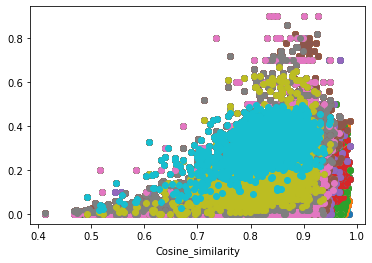

In [ ]:
summary = open(os.path.join(output_folder, 'summary_results.csv'), 'w+')
writer = csv.writer(summary, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
writer.writerow(['min_freq','max_freq', 'top_n', 'vocab1_filtered', 'vocab2_filtered', 
                 'Spearman correlation cosine_sim-neighbour_sim', 
                 'mean_neighbourscore_chosen_words','mean_cosinescore_chosen_words',
                 'mean_neighbourscore_other_words','mean_cosinescore_other_words',
                 'mean_neighbourscore_unchanged_words','mean_cosinescore_unchanged_words',
                 'mean_neighbourscore_non_sci_words_analysed','mean_cosinescore_non_sci_words_analysed',
                 'mean_neighbourscore_sci_words_analysed','mean_cosinescore_sci_words_analysed',
                 'median_neighbourscore_chosen_words','median_cosinescore_chosen_words',
                 'median_neighbourscore_other_words','median_cosinescore_other_words',
                 'median_neighbourscore_unchanged_words','median_cosinescore_unchanged_words',
                 'median_neighbourscore_non_sci_words_analysed','median_cosinescore_non_sci_words_analysed',
                 'median_neighbourscore_sci_words_analysed','median_cosinescore_sci_words_analysed'])
min_freq_values = [0,1,5,10,50]
max_freq_values = [10000,100000,200000]
top_n_values = [10,50,100,1000]
for min_freq in min_freq_values:
  for max_freq in max_freq_values:
    for top_n in top_n_values:
      print(min_freq, max_freq, top_n)
      [vocab1_filtered, vocab2_filtered, vocab_filtered, corr, 
       mean_cos_chosen, mean_nei_chosen, mean_cos_other, mean_nei_other, mean_cos_unchanged, mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian, mean_cos_scian, mean_nei_scian, 
       median_cos_chosen, median_nei_chosen, median_cos_other, median_nei_other, median_cos_unchanged, median_nei_unchanged, median_cos_nonscian, median_nei_nonscian, median_cos_scian, median_nei_scian] = compare_two_methods(min_freq, max_freq, top_n)
      writer.writerow([min_freq, max_freq, top_n, len(vocab1_filtered), len(vocab2_filtered), corr,
                 mean_cos_chosen,mean_nei_chosen,mean_cos_other,mean_nei_other,mean_cos_unchanged,mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian,mean_cos_scian,mean_nei_scian,
                 median_cos_chosen,median_nei_chosen,median_cos_other,median_nei_other,median_cos_unchanged,median_nei_unchanged, median_cos_nonscian, median_nei_nonscian,median_cos_scian,median_nei_scian])
summary.close()